<a href="https://colab.research.google.com/github/jagdishgg/GANs/blob/main/Jagdish_MRI_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob

In [2]:
import os

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
from google.colab import files

os.chdir('/content/gdrive/MyDrive')


In [5]:
os.chdir('/content/gdrive/MyDrive/kaggle/MRI_Dataset')

In [6]:
!dir

Tr1  Tr2


In [7]:
t1_path = "/content/gdrive/MyDrive/kaggle/MRI_Dataset/Tr1/TrainT1"
t2_path = "/content/gdrive/MyDrive/kaggle/MRI_Dataset/Tr2/TrainT2"

In [8]:
t1_images = os.listdir(t1_path)
t2_images = os.listdir(t2_path)
# Validating filename extraction
t1_images[2]

'Image #48.png'

In [9]:
im1= imageio.imread(t1_path+ '/' + t1_images[2])

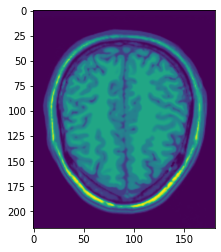

In [10]:
plt.imshow(im1)

In [11]:
def extract_images(ospath, imgfolder):
    img_list = []
    for file in imgfolder:
        img = imageio.imread(ospath+ '/' + file)
        img_list.append(img)
    return np.asarray(img_list) # converts list to a numpy array

In [12]:
t1 = extract_images(t1_path, t1_images)
t2 = extract_images(t2_path, t2_images)
print('T1 Shape: ',t1.shape)
print('T2 Shape: ',t2.shape)
print('Dataset size: ', t1.shape[0]+t2.shape[0])

T1 Shape:  (43, 217, 181)
T2 Shape:  (46, 217, 181)
Dataset size:  89


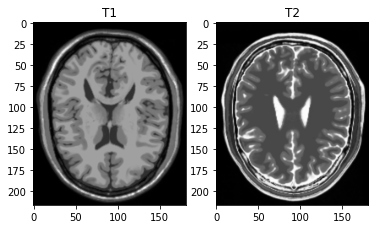

In [13]:
plt.subplot(1, 2, 1)
#plt.figure(figsize=(3, 3))
plt.imshow(t1[4], cmap='gray')
#fig.axis('off')
plt.title('T1')

plt.subplot(1, 2, 2)
#plt.figure(figsize=(3, 3))
plt.imshow(t2[4], cmap='gray')
#plt.axis('off')
plt.title('T2')
plt.show()

In [14]:
def normalize(img):
    img = (img/127.5)-1.0 # Normalize the images to [-1.0, 1.0]
    return img

In [15]:
t1 = normalize(t1)
t2 = normalize(t2)

### After normalising 

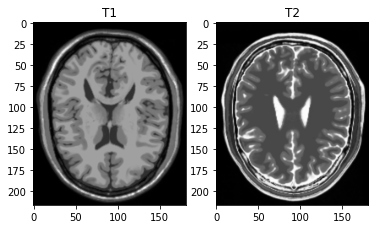

In [16]:
plt.subplot(1, 2, 1)
#plt.figure(figsize=(3, 3))
plt.imshow(t1[4], cmap='gray')
#fig.axis('off')
plt.title('T1')

plt.subplot(1, 2, 2)
#plt.figure(figsize=(3, 3))
plt.imshow(t2[4], cmap='gray')
#plt.axis('off')
plt.title('T2')
plt.show()

In [17]:
def resize_img(imgs):
    img_resized = np.zeros((imgs.shape[0], 64, 64))
    for index, img in enumerate(imgs):
        img_resized[index, :, :] = resize(img, (64, 64))
    return img_resized

In [18]:
t1_resize = resize_img(t1)
t2_resize = resize_img(t2)
print('T1 Shape: ',t1_resize.shape)
print('T2 Shape: ',t2_resize.shape)

T1 Shape:  (43, 64, 64)
T2 Shape:  (46, 64, 64)


Reshape Images to (64, 64, 1) with float pixel values

In [19]:
t1_data = t1_resize.reshape(t1_resize.shape[0], 64, 64, 1).astype('float32')
t2_data = t2_resize.reshape(t2_resize.shape[0], 64, 64, 1).astype('float32')

Batch and shuffle the data

In [20]:
BATCH_SIZE = 32
t1_resized = tf.data.Dataset.from_tensor_slices(t1_data).shuffle(t1.shape[0], seed=42).batch(BATCH_SIZE)
t2_resized = tf.data.Dataset.from_tensor_slices(t2_data).shuffle(t2.shape[0], seed=42).batch(BATCH_SIZE)

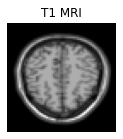

In [21]:
t1_sample = next(iter(t1_resized))
plt.figure(figsize=(2, 2))
plt.imshow(t1_sample[0].numpy()[:, :, 0], cmap='gray')
plt.title('T1 MRI')
plt.axis('off')
plt.show()

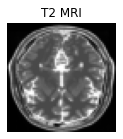

In [22]:
t2_sample = next(iter(t2_resized))
plt.figure(figsize=(2, 2))
plt.imshow(t2_sample[0].numpy()[:, :, 0], cmap='gray')
plt.title('T2 MRI')
plt.axis('off')
plt.show()

Model Building

Instance Normalization

Downsampling, Upsampling and Unet

Generator Building using Unet

Discriminator Building

Instance Normalization

Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

**Model Building & Training**

In [23]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [24]:
# Downsampling method: Leads to reduction in dimensions, achieved with convolutions
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [25]:
# Upsampling method: Achieved with Conv2DTranspose 
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [26]:
# Unet Generator: A combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(128, 4, False), # (bs, 32, 32, 128)
        downsample(256, 4), # (bs, 16, 16, 256)
        downsample(256, 4), # (bs, 8, 8, 256)
        downsample(256, 4), # (bs, 4, 4, 256)
        downsample(256, 4), # (bs, 2, 2, 256)
        downsample(256, 4) # (bs, 1, 1, 256)
    ]
    up_stack = [
        upsample(256, 4, True), # (bs, 2, 2, 256)
        upsample(256, 4, True), # (bs, 4, 4, 256)
        upsample(256, 4), #(bs, 8, 8, 256)
        upsample(256, 4),# (bs, 16, 16, 256)
        upsample(128, 4) # (bs, 32, 32, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 64, 64, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[64, 64, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

**Creating generator**

In [27]:
generator_g = unet_generator()
generator_f = unet_generator()

In [28]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 128)  2048        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 16, 16, 256)  524800      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 8, 8, 256)    1049088     ['sequential_1[0][0]']           
                                                                                              

**Discriminator**

In [47]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (64, 64, 1)
    inp = tf.keras.layers.Input(shape=[64, 64, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(128, 4, False)(x) # (bs, 32, 32, 128)
    down2 = downsample(256, 4)(down1) # (bs, 16, 16, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 18, 18, 256)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 15, 15, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 512)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [48]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [49]:
discriminator_x.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 sequential_26 (Sequential)  (None, 32, 32, 128)       2048      
                                                                 
 sequential_27 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 18, 18, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 15, 15, 512)       2097152   
                                                                 
 instance_normalization_25 (  (None, 15, 15, 512)      1024      
 InstanceNormalization)                                    

**Model Training**

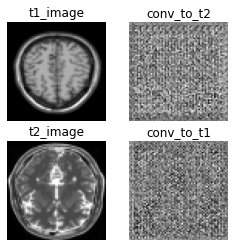

In [50]:
# Verify output of untrained Generator models which should be a random noise
conv_to_t2 = generator_g(t1_sample)
conv_to_t1 = generator_f(t2_sample)
plt.figure(figsize=(4, 4))

imgs = [t1_sample, conv_to_t2, t2_sample, conv_to_t1]
title = ['t1_image', 'conv_to_t2', 't2_image', 'conv_to_t1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

**Creating the loss function**

In [51]:
# Classification loss of discriminator: BCE Loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [52]:
# Discriminator Loss: Real Loss + Fake Loss)
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

**Generator Loss**

It has only one type of loss - Discriminator Loss on Generated data

In [53]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [54]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

**Identity Loss**

When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

In [55]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

In [56]:
# Leveraging Adam Optimizer to smoothen gradient descent
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [70]:
# Training model for 100 epochs
EPOCHS = 100

**Checkpoint Initialization**

In [58]:
# Initialize checkpoints to save models
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [59]:
# Definition to show generated output whilst training
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Generated Image', 'Input Image', 'Generated Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

**Defining Training Function**

In [60]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [72]:
# Verify if GPU is set as the default device for training
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



**Training the CycleGAN**

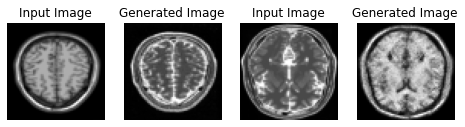

Saving checkpoint for epoch 1 at ./Trained_Model/ckpt-239


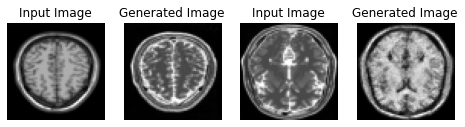

Saving checkpoint for epoch 2 at ./Trained_Model/ckpt-240


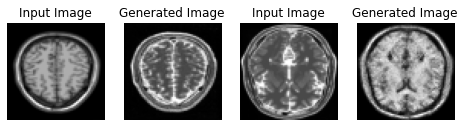

Saving checkpoint for epoch 3 at ./Trained_Model/ckpt-241


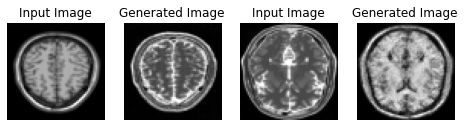

Saving checkpoint for epoch 4 at ./Trained_Model/ckpt-242


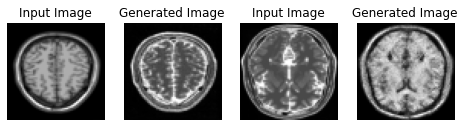

Saving checkpoint for epoch 5 at ./Trained_Model/ckpt-243


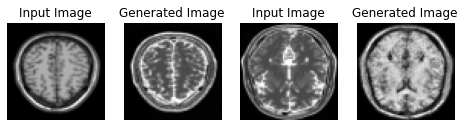

Saving checkpoint for epoch 6 at ./Trained_Model/ckpt-244


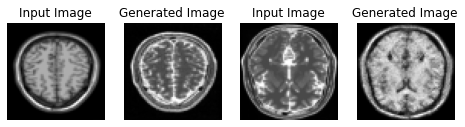

Saving checkpoint for epoch 7 at ./Trained_Model/ckpt-245


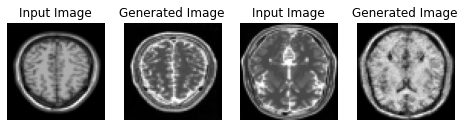

Saving checkpoint for epoch 8 at ./Trained_Model/ckpt-246


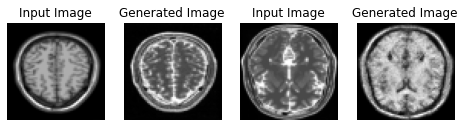

Saving checkpoint for epoch 9 at ./Trained_Model/ckpt-247


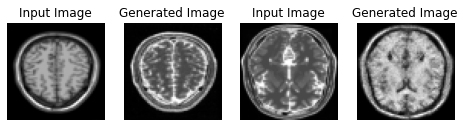

Saving checkpoint for epoch 10 at ./Trained_Model/ckpt-248


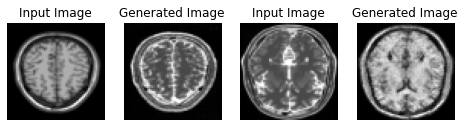

Saving checkpoint for epoch 11 at ./Trained_Model/ckpt-249


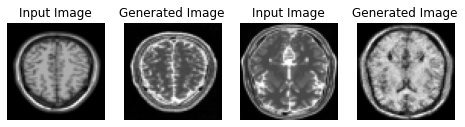

Saving checkpoint for epoch 12 at ./Trained_Model/ckpt-250


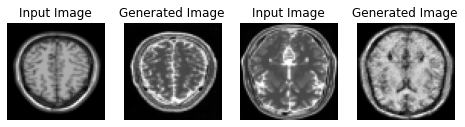

Saving checkpoint for epoch 13 at ./Trained_Model/ckpt-251


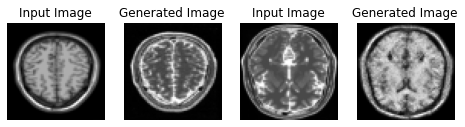

Saving checkpoint for epoch 14 at ./Trained_Model/ckpt-252


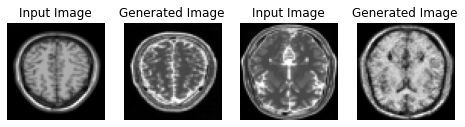

Saving checkpoint for epoch 15 at ./Trained_Model/ckpt-253


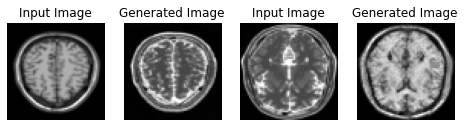

Saving checkpoint for epoch 16 at ./Trained_Model/ckpt-254


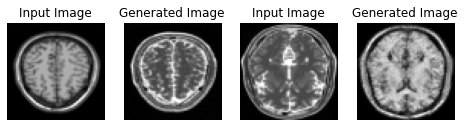

Saving checkpoint for epoch 17 at ./Trained_Model/ckpt-255


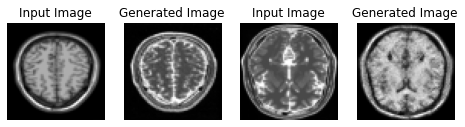

Saving checkpoint for epoch 18 at ./Trained_Model/ckpt-256


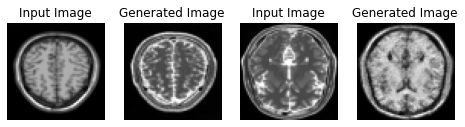

Saving checkpoint for epoch 19 at ./Trained_Model/ckpt-257


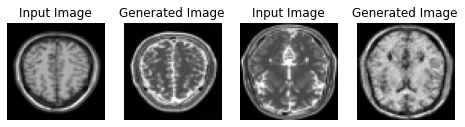

Saving checkpoint for epoch 20 at ./Trained_Model/ckpt-258


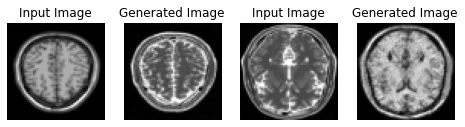

Saving checkpoint for epoch 21 at ./Trained_Model/ckpt-259


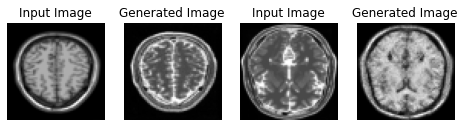

Saving checkpoint for epoch 22 at ./Trained_Model/ckpt-260


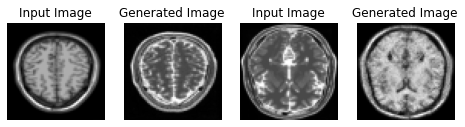

Saving checkpoint for epoch 23 at ./Trained_Model/ckpt-261


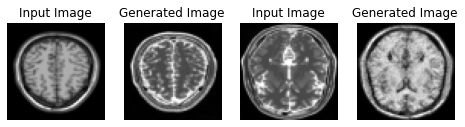

Saving checkpoint for epoch 24 at ./Trained_Model/ckpt-262


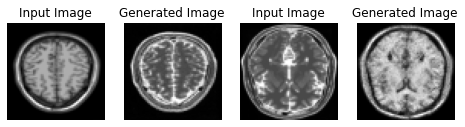

Saving checkpoint for epoch 25 at ./Trained_Model/ckpt-263


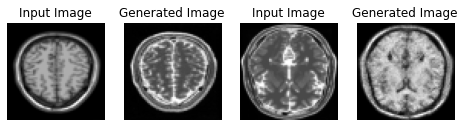

Saving checkpoint for epoch 26 at ./Trained_Model/ckpt-264


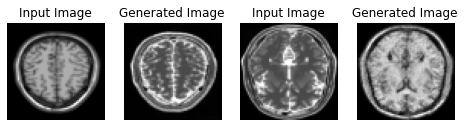

Saving checkpoint for epoch 27 at ./Trained_Model/ckpt-265


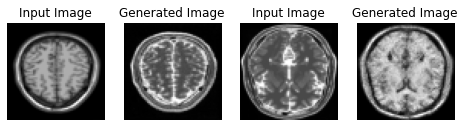

Saving checkpoint for epoch 28 at ./Trained_Model/ckpt-266


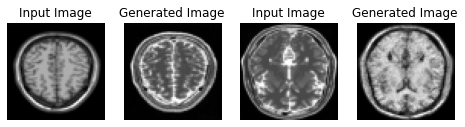

Saving checkpoint for epoch 29 at ./Trained_Model/ckpt-267


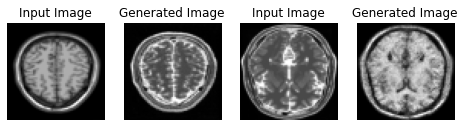

Saving checkpoint for epoch 30 at ./Trained_Model/ckpt-268


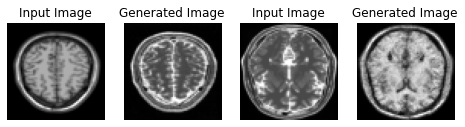

Saving checkpoint for epoch 31 at ./Trained_Model/ckpt-269


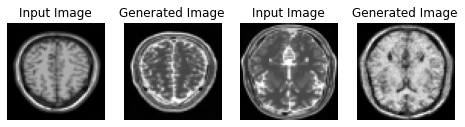

Saving checkpoint for epoch 32 at ./Trained_Model/ckpt-270


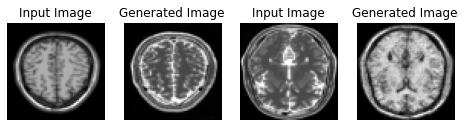

Saving checkpoint for epoch 33 at ./Trained_Model/ckpt-271


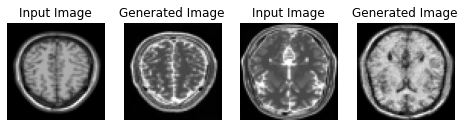

Saving checkpoint for epoch 34 at ./Trained_Model/ckpt-272


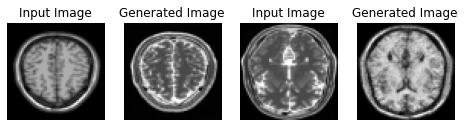

Saving checkpoint for epoch 35 at ./Trained_Model/ckpt-273


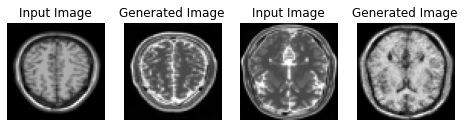

Saving checkpoint for epoch 36 at ./Trained_Model/ckpt-274


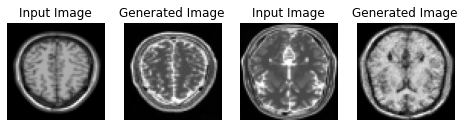

Saving checkpoint for epoch 37 at ./Trained_Model/ckpt-275


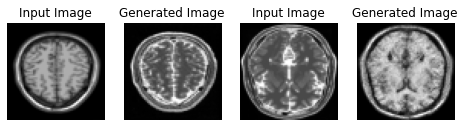

Saving checkpoint for epoch 38 at ./Trained_Model/ckpt-276


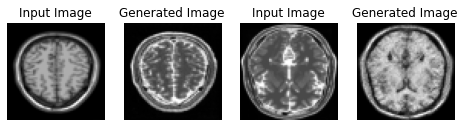

Saving checkpoint for epoch 39 at ./Trained_Model/ckpt-277


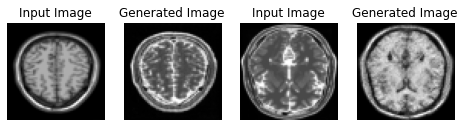

Saving checkpoint for epoch 40 at ./Trained_Model/ckpt-278


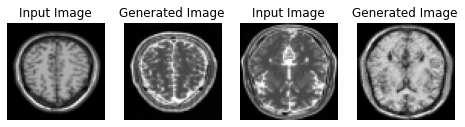

Saving checkpoint for epoch 41 at ./Trained_Model/ckpt-279


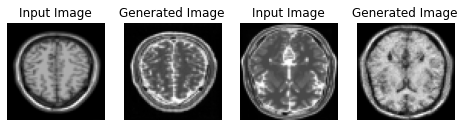

Saving checkpoint for epoch 42 at ./Trained_Model/ckpt-280


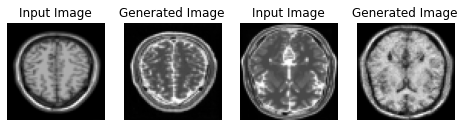

Saving checkpoint for epoch 43 at ./Trained_Model/ckpt-281


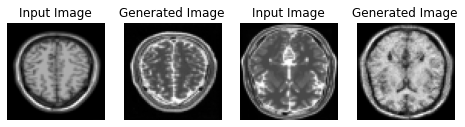

Saving checkpoint for epoch 44 at ./Trained_Model/ckpt-282


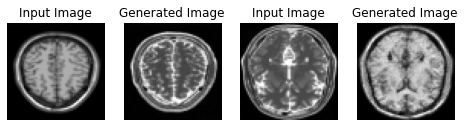

Saving checkpoint for epoch 45 at ./Trained_Model/ckpt-283


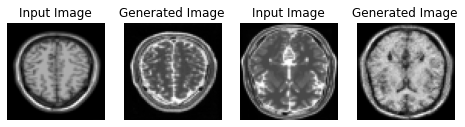

Saving checkpoint for epoch 46 at ./Trained_Model/ckpt-284


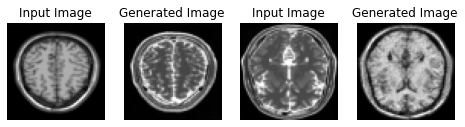

Saving checkpoint for epoch 47 at ./Trained_Model/ckpt-285


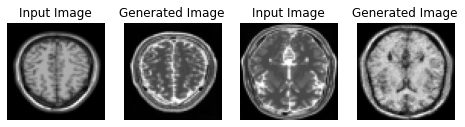

Saving checkpoint for epoch 48 at ./Trained_Model/ckpt-286


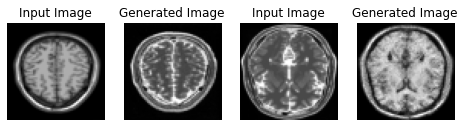

Saving checkpoint for epoch 49 at ./Trained_Model/ckpt-287


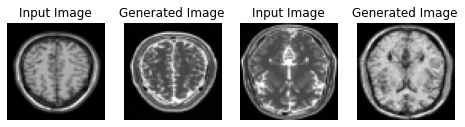

Saving checkpoint for epoch 50 at ./Trained_Model/ckpt-288


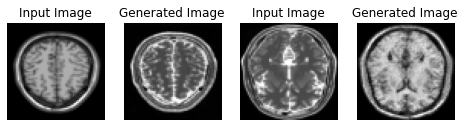

Saving checkpoint for epoch 51 at ./Trained_Model/ckpt-289


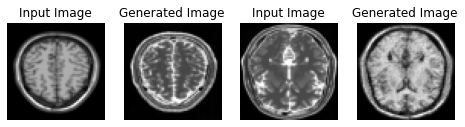

Saving checkpoint for epoch 52 at ./Trained_Model/ckpt-290


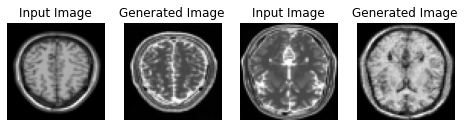

Saving checkpoint for epoch 53 at ./Trained_Model/ckpt-291


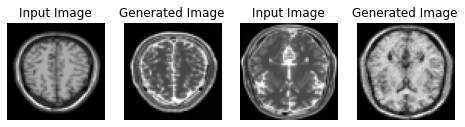

Saving checkpoint for epoch 54 at ./Trained_Model/ckpt-292


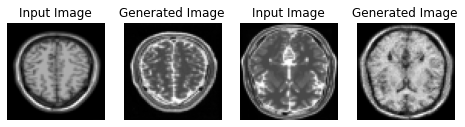

Saving checkpoint for epoch 55 at ./Trained_Model/ckpt-293


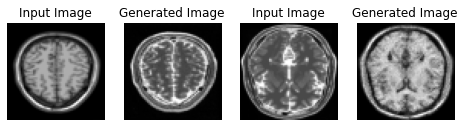

Saving checkpoint for epoch 56 at ./Trained_Model/ckpt-294


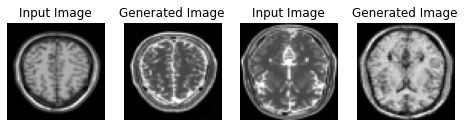

Saving checkpoint for epoch 57 at ./Trained_Model/ckpt-295


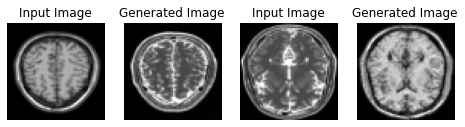

Saving checkpoint for epoch 58 at ./Trained_Model/ckpt-296


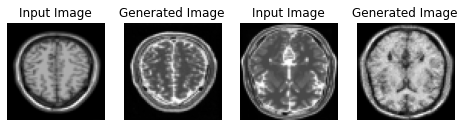

Saving checkpoint for epoch 59 at ./Trained_Model/ckpt-297


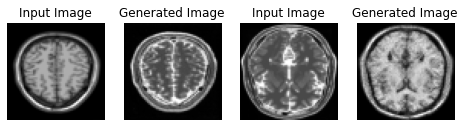

Saving checkpoint for epoch 60 at ./Trained_Model/ckpt-298


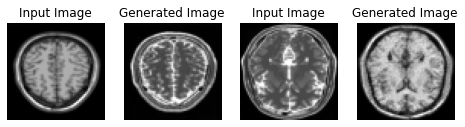

Saving checkpoint for epoch 61 at ./Trained_Model/ckpt-299


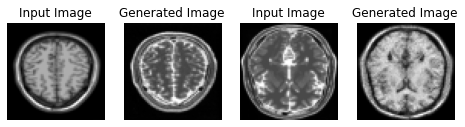

Saving checkpoint for epoch 62 at ./Trained_Model/ckpt-300


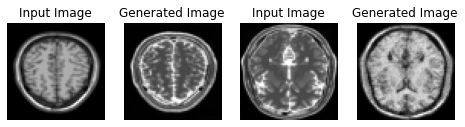

Saving checkpoint for epoch 63 at ./Trained_Model/ckpt-301


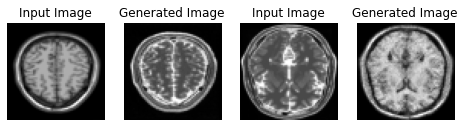

Saving checkpoint for epoch 64 at ./Trained_Model/ckpt-302


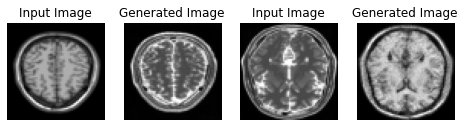

Saving checkpoint for epoch 65 at ./Trained_Model/ckpt-303


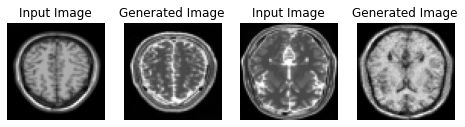

Saving checkpoint for epoch 66 at ./Trained_Model/ckpt-304


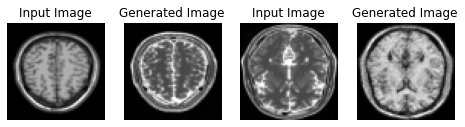

Saving checkpoint for epoch 67 at ./Trained_Model/ckpt-305


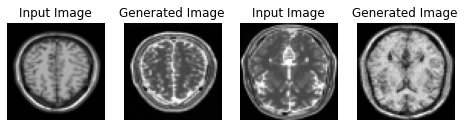

Saving checkpoint for epoch 68 at ./Trained_Model/ckpt-306


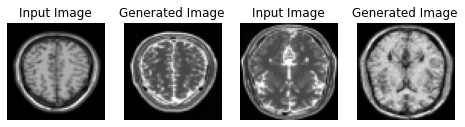

Saving checkpoint for epoch 69 at ./Trained_Model/ckpt-307


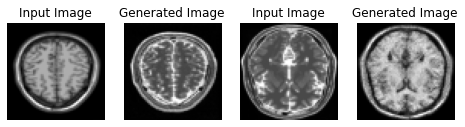

Saving checkpoint for epoch 70 at ./Trained_Model/ckpt-308


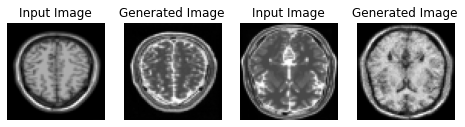

Saving checkpoint for epoch 71 at ./Trained_Model/ckpt-309


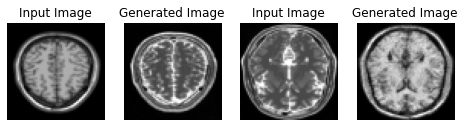

Saving checkpoint for epoch 72 at ./Trained_Model/ckpt-310


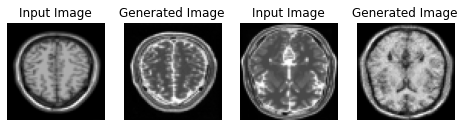

Saving checkpoint for epoch 73 at ./Trained_Model/ckpt-311


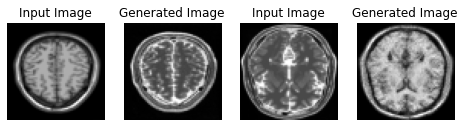

Saving checkpoint for epoch 74 at ./Trained_Model/ckpt-312


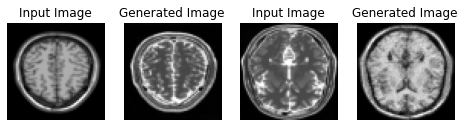

Saving checkpoint for epoch 75 at ./Trained_Model/ckpt-313


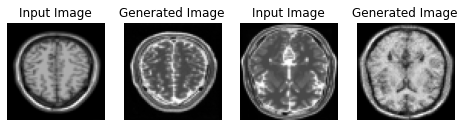

Saving checkpoint for epoch 76 at ./Trained_Model/ckpt-314


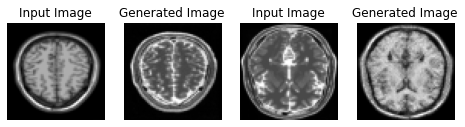

Saving checkpoint for epoch 77 at ./Trained_Model/ckpt-315


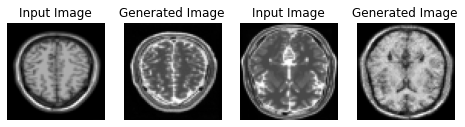

Saving checkpoint for epoch 78 at ./Trained_Model/ckpt-316


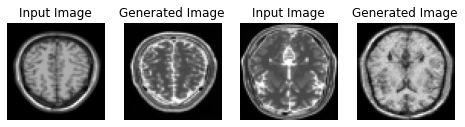

Saving checkpoint for epoch 79 at ./Trained_Model/ckpt-317


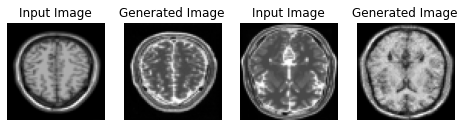

Saving checkpoint for epoch 80 at ./Trained_Model/ckpt-318


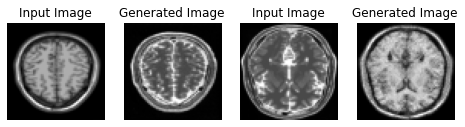

Saving checkpoint for epoch 81 at ./Trained_Model/ckpt-319


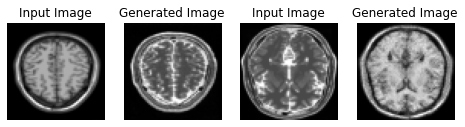

ResourceExhaustedError: ignored

In [73]:
%%time
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((t1_resized, t2_resized)):
        train_step(image_x, image_y)
    generate_images(generator_g, t1_sample, generator_f, t2_sample)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [ ]:
anim_file2 = 'cyclegan_mri.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file2 )
